In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
paths = ['CityscapesDaten/images/00000110_01.png',
         'CityscapesDaten/images/00000125_01.png',
         'CityscapesDaten/images/00000523_01.png',
         'CityscapesDaten/images/000003368_01.png', 
         ]

path_ground = ['CityscapesDaten/semantic/00000110_01.png',
         'CityscapesDaten/semantic/00000125_01.png',
         'CityscapesDaten/semantic/00000523_01.png',
         'CityscapesDaten/semantic/000003368_01.png', 
         ]

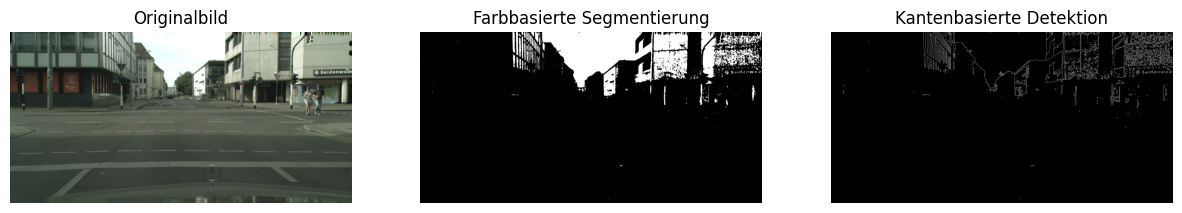

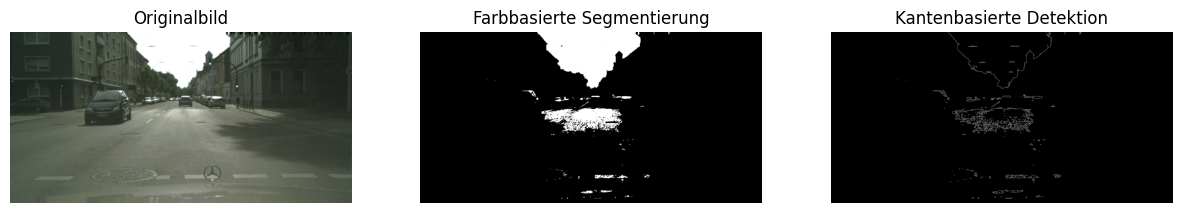

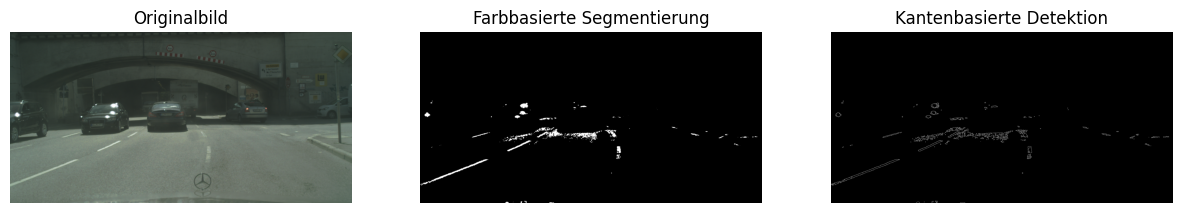

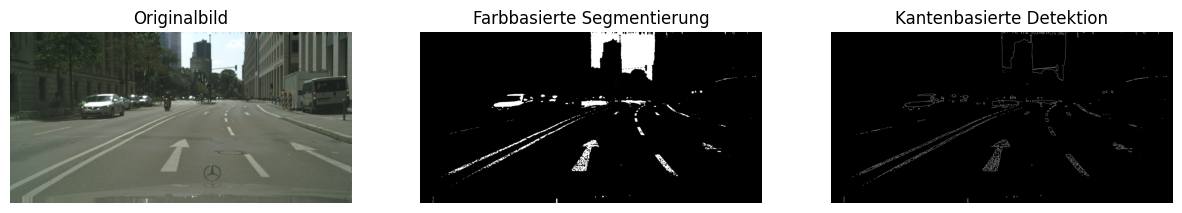

In [3]:

for path in paths:
    # Bild laden
    image = cv2.imread(path)
    if image is None:
        print(f"Fehler: Bild konnte nicht geladen werden - {path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Vorverarbeitung: Rauschreduzierung
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Umwandlung in den HSV-Farbraum
    hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)

    # Farbsegmentierung für weiße und gelbe Fahrbahnmarkierungen
    lower_white = np.array([0, 0, 150])
    upper_white = np.array([255, 30, 255])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    lower_yellow = np.array([15, 100, 100])
    upper_yellow = np.array([35, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Kombination der Masken
    mask_combined = cv2.bitwise_or(mask_white, mask_yellow)

    # Anwendung der Masken auf das Originalbild
    filtered = cv2.bitwise_and(image, image, mask=mask_combined)

    # Graustufenbild für Canny-Kantendetektion
    gray = cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY)

    # Canny-Kantendetektion
    edges = cv2.Canny(gray, 40, 120)

    # Anzeigen der Ergebnisse für jedes Bild
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title("Originalbild")
    axs[0].axis("off")

    axs[1].imshow(mask_combined, cmap='gray')
    axs[1].set_title("Farbbasierte Segmentierung")
    axs[1].axis("off")

    axs[2].imshow(edges, cmap='gray')
    axs[2].set_title("Kantenbasierte Detektion")
    axs[2].axis("off")

    plt.show()


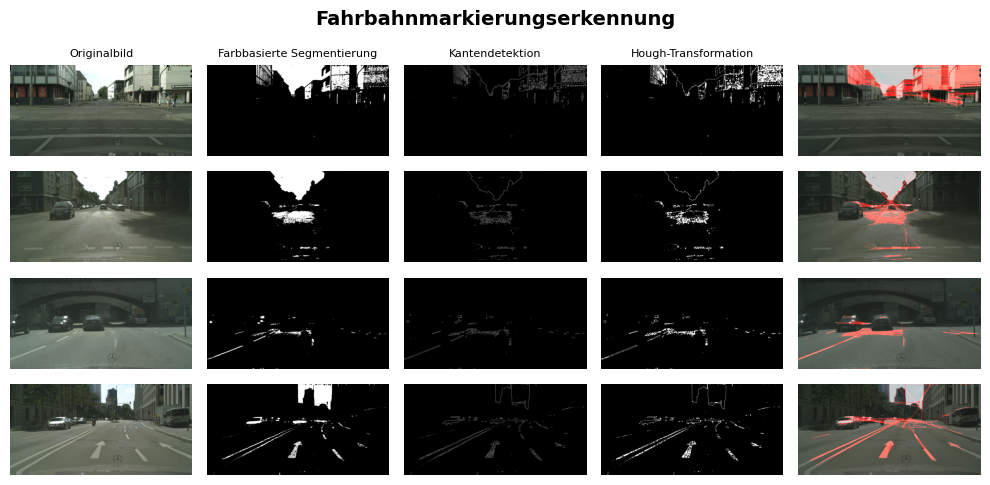

In [ ]:
# Jupyter Notebook Zelle: Implementierung basierend auf Hernández et al. (2016) ohne Hough-Filterung

# A4-Seitengröße im Querformat definieren
fig, axes = plt.subplots(4, 5, figsize=(10, 5))  # Querformat: 5 Zeilen, 5 Bilder pro Zeile

# Funktion zur Verarbeitung eines Bildes basierend auf Hernández et al. (2016)
def process_lane_detection(image):
    """
    Implementierung nach Hernández et al. (2016):
    - Farbraumbasierte Segmentierung (HSV)
    - Sobel-Kantendetektion
    - Otsu-Thresholding für adaptive Binärsegmentierung
    - Morphologische Operationen zur Lücken-Schließung
    - Hough-Transformation für Linienextraktion (ohne Filterung)
    """
    # 1. Vorverarbeitung: Rauschreduzierung
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # 2. Umwandlung in den HSV-Farbraum
    hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)

    # 3. Farbsegmentierung für weiße und gelbe Fahrbahnmarkierungen
    mask_white = cv2.inRange(hsv, np.array([0, 0, 150]), np.array([255, 30, 255]))
    mask_yellow = cv2.inRange(hsv, np.array([15, 80, 120]), np.array([40, 255, 255]))

    # Kombination der Masken
    mask_combined = cv2.bitwise_or(mask_white, mask_yellow)

    # Anwendung der Masken auf das Originalbild
    filtered = cv2.bitwise_and(image, image, mask=mask_combined)

    # 4. Umwandlung in Graustufen für Kantenerkennung
    gray = cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY)

    # 5. Kantenerkennung mit Sobel-Operator
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobelx, sobely)
    sobel_edges = np.uint8(sobel_edges / np.max(sobel_edges) * 255)  # Normalisieren auf 0-255

    # 6. Otsu's Thresholding für adaptive Binärsegmentierung
    _, binary_sobel = cv2.threshold(sobel_edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 7. Morphologische Operationen zur Verbesserung der Segmentierung (Closing)
    kernel = np.ones((3, 3), np.uint8)
    closed_edges = cv2.morphologyEx(binary_sobel, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 8. Hough-Transformation zur Linienextraktion (keine Filterung)
    lines = cv2.HoughLinesP(closed_edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=150)
    line_img = np.zeros_like(image)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blaue Linien für bessere Sichtbarkeit

    # 9. Überlagerung der Linien auf das Originalbild
    final_result = cv2.addWeighted(image, 0.8, line_img, 1, 0)

    return image, mask_combined, sobel_edges, closed_edges, final_result

# Titel für die Spalten über dem gesamten Plot setzen
column_titles = ["Originalbild", "Farbbasierte Segmentierung", "Kantendetektion", "Hough-Transformation"]
plt.suptitle("Fahrbahnmarkierungserkennung", fontsize=14, fontweight="bold")


# Verarbeitung der Bilder und Darstellung
for i, path in enumerate(paths):
    image = cv2.imread(path)
    if image is None:
        print(f"Fehler: Bild konnte nicht geladen werden - {path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    orig, mask, sobel, morph, hough = process_lane_detection(image)

    # Ergebnisse in der A4-Darstellung anzeigen
    axes[i, 0].imshow(orig)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis("off")

    axes[i, 2].imshow(sobel, cmap='gray')
    axes[i, 2].axis("off")

    axes[i, 3].imshow(morph, cmap='gray')
    axes[i, 3].axis("off")

    axes[i, 4].imshow(hough)
    axes[i, 4].axis("off")

# Anzeige optimieren: Weniger Abstand, keine Achsenbeschriftung
plt.subplots_adjust(wspace=0.01, hspace=0.01)
# Titel für die Spalten über jeder Spalte einfügen
for ax, title in zip(axes[0], column_titles):
    ax.set_title(title, fontsize=8)
plt.tight_layout()
plt.savefig("FINAL_DATEN/Bilder_Studienarbeit/Fahrbahnmarkierungserkennung.png", dpi=300, bbox_inches="tight")
plt.show()


In [5]:
# Funktion zur Verarbeitung eines Bildes mit Ground Truth zur Straßenextraktion
def process_lane_detection_with_gt(image, gt_image):
    """
    Pipeline mit Ground-Truth-basierter Straßenextraktion + traditioneller Fahrspurerkennung:
    1. Ground Truth verwenden, um nur die Straße aus dem Originalbild zu extrahieren.
    2. Klassische Fahrspurerkennung (HSV, Sobel, Otsu, Morphologie, Hough) darauf anwenden.
    """
    # 1. Ground Truth Maske für "Straße" erstellen (Channel 0)
    road_mask = (gt_image[:, :, 0] == 0).astype(np.uint8) * 255  # Invertiert: Straße bleibt bestehen!

    # 2. Segmentierung des Originalbildes → Bild enthält nur Straße
    road_only = cv2.bitwise_and(image, image, mask=road_mask)

    # 3. Vorverarbeitung: Rauschreduzierung
    blurred = cv2.GaussianBlur(road_only, (5, 5), 0)

    # 4. Umwandlung in den HSV-Farbraum
    hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)

    # 5. Farbsegmentierung für weiße und gelbe Fahrbahnmarkierungen
    mask_white = cv2.inRange(hsv, np.array([0, 0, 150]), np.array([255, 30, 255]))
    mask_yellow = cv2.inRange(hsv, np.array([15, 80, 120]), np.array([40, 255, 255]))

    # Kombination der Masken
    mask_combined = cv2.bitwise_or(mask_white, mask_yellow)

    # 6. Anwendung der Masken auf das Originalbild
    filtered = cv2.bitwise_and(road_only, road_only, mask=mask_combined)

    # 7. Umwandlung in Graustufen für Kantenerkennung
    gray = cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY)

    # 8. Kantenerkennung mit Sobel-Operator
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobelx, sobely)
    sobel_edges = np.uint8(sobel_edges / np.max(sobel_edges) * 255)  # Normalisieren auf 0-255

    # 9. Otsu's Thresholding für adaptive Binärsegmentierung
    _, binary_sobel = cv2.threshold(sobel_edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 10. Morphologische Operationen zur Verbesserung der Segmentierung (Closing)
    kernel = np.ones((3, 3), np.uint8)
    closed_edges = cv2.morphologyEx(binary_sobel, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 11. Hough-Transformation zur Linienextraktion
    lines = cv2.HoughLinesP(closed_edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=150)
    line_img = np.zeros_like(image)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blaue Linien für bessere Sichtbarkeit

    # 12. Überlagerung der Linien auf das Originalbild
    final_result = cv2.addWeighted(road_only, 0.8, line_img, 1, 0)

    return image, road_only, mask_combined, closed_edges, final_result

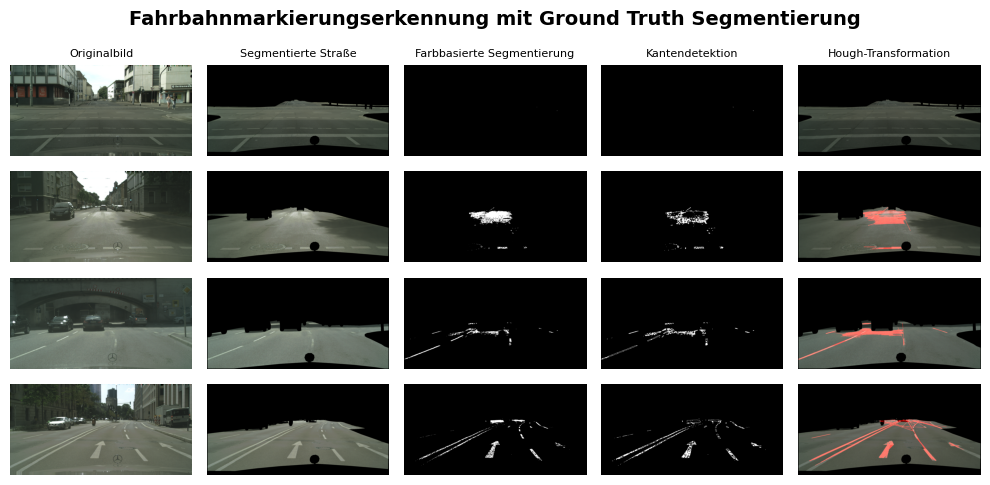

In [6]:

# Neue Jupyter-Zelle: Optimierte Darstellung mit weniger Zeilenabstand + nur eine Titelzeile

# A4-Seitengröße im Querformat definieren (4 Zeilen Bilder + 1 Zeile für Titel)
fig, axes = plt.subplots(4, 5, figsize=(10, 5))  # Querformat: 5 Spalten, 4 Zeilen

# Titel für die Spalten über dem gesamten Plot setzen
column_titles = ["Originalbild", "Segmentierte Straße", "Farbbasierte Segmentierung", "Kantendetektion", "Hough-Transformation"]
plt.suptitle("Fahrbahnmarkierungserkennung mit Ground Truth Segmentierung", fontsize=14, fontweight="bold")

# Verarbeitung der Bilder mit Ground Truth und Darstellung
for i, (img_path, gt_path) in enumerate(zip(paths[:4], path_ground[:4])):  # Nur 4 Bilder behandeln
    # Originalbild laden
    image = cv2.imread(img_path)
    if image is None:
        print(f"Fehler: Bild konnte nicht geladen werden - {img_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Ground-Truth-Bild laden
    gt_image = cv2.imread(gt_path)
    if gt_image is None:
        print(f"Fehler: Ground Truth konnte nicht geladen werden - {gt_path}")
        continue
    gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB)  # Falls Ground Truth nicht in Graustufen ist

    orig, road, mask, morph, hough = process_lane_detection_with_gt(image, gt_image)

    # Ergebnisse in der A4-Darstellung anzeigen
    axes[i, 0].imshow(orig)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(road)
    axes[i, 1].axis("off")

    axes[i, 2].imshow(mask, cmap='gray')
    axes[i, 2].axis("off")

    axes[i, 3].imshow(morph, cmap='gray')
    axes[i, 3].axis("off")

    axes[i, 4].imshow(hough)
    axes[i, 4].axis("off")

# Abstand zwischen Zeilen verringern, um kompaktere Darstellung zu ermöglichen
plt.subplots_adjust(wspace=0.01, hspace=0.02)  # Geringerer vertikaler Abstand für kompaktere Ansicht

# Titel für die Spalten über jeder Spalte einfügen
for ax, title in zip(axes[0], column_titles):
    ax.set_title(title, fontsize=8)
plt.tight_layout()
plt.savefig("FINAL_DATEN/Bilder_Studienarbeit/Fahrbahnmarkierungserkennung mit Ground Truth Segmentierung.png", dpi=300, bbox_inches="tight")
plt.show()
